<a href="https://www.kaggle.com/code/hamidrezabakhtaki/tp-sep-2022-eda-lasso-ridge-lr?scriptVersionId=105863047" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-sep-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-sep-2022/train.csv
/kaggle/input/tabular-playground-series-sep-2022/test.csv


In [2]:
import os
import sys
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import scipy
import missingno as msno
import colorama
import gc
import timeit
import time
import shutil
import random
from colorama import Fore, Back, Style
%matplotlib inline
warnings.filterwarnings("ignore")
!pip install feature_engine


# Tools
from sklearn.preprocessing import LabelEncoder, power_transform, OneHotEncoder,StandardScaler,minmax_scale ,MinMaxScaler ,RobustScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline




# Libraries
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report,log_loss
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor , RandomForestRegressor , ExtraTreesRegressor
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, RepeatedStratifiedKFold, RandomizedSearchCV, GridSearchCV ,GroupKFold, KFold
from sklearn.neighbors import KNeighborsRegressor

import optuna
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 1.4 MB/s eta 0:00:00


# **Data Import**

In [3]:
train_df = pd.read_csv('../input/tabular-playground-series-sep-2022/train.csv',index_col="row_id")

In [4]:
test_df = pd.read_csv('../input/tabular-playground-series-sep-2022/test.csv',index_col="row_id")

In [5]:
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

In [6]:
train_df.head()

,date,country,store,product,num_sold
row_id,,,,,
0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240


In [7]:
test_df.head(5)

,date,country,store,product
row_id,,,,
70128,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques
70129,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started
70130,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book
70131,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose
70132,2021-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques


# **Data Analayze**

In [8]:
# Decorator Fucntion to Evaluate Execuation timr of each Cell
def timed_func(func_to_time):
    def timed(*args, **kwargs):
        start_time = time.perf_counter()
        out_put = func_to_time(*args, **kwargs)
        print('Total Execution Time is :',time.perf_counter() - start_time,'\n')
        return out_put
    return timed

In [9]:
@timed_func
def get_continuous_columns(dataframe,verbose=True):
    """
    Use this function to retun countinous  columns of a dataframe
    input : dataframe
    output: list 
    
    """
    
    continuos_column = []
    for column in dataframe.columns:
        if dataframe.dtypes[column] in ['float16' ,'float32' ,'float64']:
            continuos_column.append(column)
    print(f'There are {len(continuos_column)} continous  columns  in Datframe:\n')
    print(continuos_column,end="")
    print("\n")
    return continuos_column

In [10]:
@timed_func
def get_categorical_columns(dataframe,verbose=True):
    """
    Use this function to retun categorical columns of a dataframe
    input : dataframe
    output: list 
    
    """
    categorical_columns = []
    for column in dataframe.columns :
        if dataframe.dtypes[column] in ['int8' ,'int16',"int32" ,"int64" ,'uint8']:
            categorical_columns.append(column)
    print(f'There are {len(categorical_columns)} categorical columns in Dataframe:]\n',end='')
    print(categorical_columns,end='')
    print("\n")
    return categorical_columns

In [11]:
@timed_func
def get_object_columns(dataframe,verbose=True):
    """
    Use this function to retun object columns of a dataframe
    input : dataframe
    output: list 
    
    """
    object_columns = []
    for column in dataframe.columns :
        if dataframe.dtypes[column] in ['object']:
            object_columns.append(column)
    print(f'There are {len(object_columns)} Objective columns in Dataframe: \n',end='')
    print(object_columns,end='')
    print("\n")
    return object_columns

In [12]:
all_features = train_df.columns.tolist()
print(all_features, end='')

['date', 'country', 'store', 'product', 'num_sold']

In [13]:
cat_columns = get_categorical_columns(train_df[all_features])
cont_columns = get_continuous_columns(train_df[all_features])
obj_columns = get_object_columns(train_df[all_features])

There are 1 categorical columns in Dataframe:]
['num_sold']

Total Execution Time is : 0.0007116870000061226 

There are 0 continous  columns  in Datframe:

[]

Total Execution Time is : 0.0005807590000017626 

There are 3 Objective columns in Dataframe: 
['country', 'store', 'product']

Total Execution Time is : 0.0006267220000211182 



In [14]:
@timed_func
def missing_rate(data_frame):
    missing_rate = {}
    for col in data_frame.columns:
        column_missing_rate = data_frame[col].isna().sum() / len(data_frame[col]) * 100
        missing_rate[col] = round(column_missing_rate,2)
    missing_rate = pd.DataFrame(missing_rate.items(), index=None)
    return missing_rate

In [15]:
missing_rate_train = missing_rate(train_df)
missing_rate_test = missing_rate(test_df)

Total Execution Time is : 0.009841189000013628 

Total Execution Time is : 0.0034732430000019576 



In [16]:
pd.concat([missing_rate_train[0].rename("Features"),missing_rate_train[1].rename("Train Mssing rate"),missing_rate_test[1].rename("Test Missing Rate")],axis=1)

,Features,Train Mssing rate,Test Missing Rate
0,date,0.0,0.0
1,country,0.0,0.0
2,store,0.0,0.0
3,product,0.0,0.0
4,num_sold,0.0,NaN


In [17]:
measurment_missings = pd.concat([train_df[cont_columns].isna().sum().rename('missing values in train'),
           round(train_df[cont_columns].isna().sum() / len(train_df[cont_columns]) * 100,2).rename("Missin Rate Train"),
           test_df[cont_columns].isna().sum().rename('missing values in test'),
          round(test_df[cont_columns].isna().sum() / len(test_df[cont_columns]) * 100,2).rename("Missin Rate Test")],
          axis=1)
measurment_missings

,missing values in train,Missin Rate Train,missing values in test,Missin Rate Test


In [18]:
cardinality_train = train_df[obj_columns + cat_columns].nunique()
cardinality_test = test_df[obj_columns].nunique()

In [19]:
data_cardinality = pd.concat([pd.DataFrame(cardinality_train.rename("Train Cardinality")),pd.DataFrame(cardinality_test.rename("Test Cardinality"))],axis=1)
data_cardinality

,Train Cardinality,Test Cardinality
country,6,6.0
store,2,2.0
product,4,4.0
num_sold,699,NaN


In [20]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
num_sold,70128.0,194.296986,126.893874,19.0,95.0,148.0,283.0,986.0


In [21]:
train_df.shape, test_df.shape

((70128, 5), (17520, 4))

In [22]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70128 entries, 0 to 70127
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      70128 non-null  datetime64[ns]
 1   country   70128 non-null  object        
 2   store     70128 non-null  object        
 3   product   70128 non-null  object        
 4   num_sold  70128 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 3.2+ MB


In [23]:
products = train_df['product'].unique().tolist()
products

['Kaggle Advanced Techniques',
 'Kaggle Getting Started',
 'Kaggle Recipe Book',
 'Kaggle for Kids: One Smart Goose']

In [24]:
countries = train_df['country'].unique().tolist()
countries

['Belgium', 'France', 'Germany', 'Italy', 'Poland', 'Spain']

In [25]:
stores =  train_df['store'].unique().tolist()
stores

['KaggleMart', 'KaggleRama']

# ***EDA***

Text(0.5, 1.0, 'Country distribution')

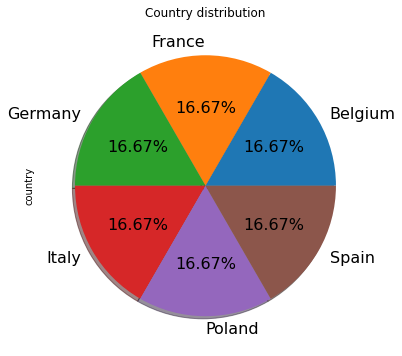

In [26]:
plt.figure(figsize=(6,6))
train_df['country'].value_counts().plot.pie(autopct='%1.2f%%', shadow=True, textprops={'fontsize':16}).set_title("Country distribution")

Text(0.5, 1.0, 'Product distribution')

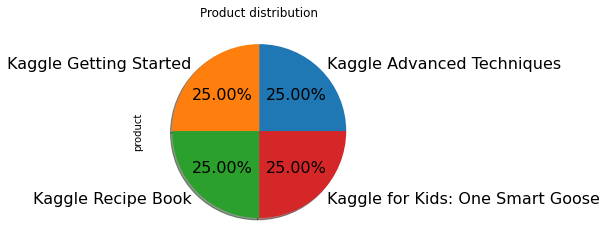

In [27]:
train_df['product'].value_counts().plot.pie(autopct='%1.2f%%', shadow=True, textprops={'fontsize':16}).set_title("Product distribution")

Text(0.5, 1.0, 'st distribution')

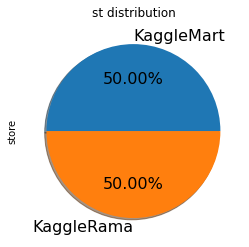

In [28]:
train_df['store'].value_counts().plot.pie(autopct='%1.2f%%', shadow=True, textprops={'fontsize':16}).set_title("st distribution")

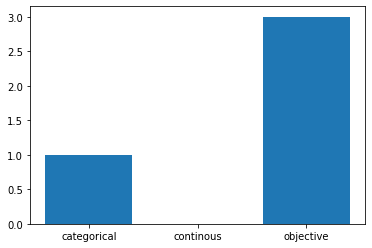

In [29]:
plt.bar([1,2,3], [len(cat_columns) ,len(cont_columns),len(obj_columns)])
plt.xticks([1,2,3] , ['categorical' , 'continous','objective'])
plt.show()

In [30]:
daily_sales = train_df.groupby('date').sum().reset_index()
daily_sales.head()

,date,num_sold
0,2017-01-01,15352
1,2017-01-02,11578
2,2017-01-03,10884
3,2017-01-04,10445
4,2017-01-05,9795


# **Trend**

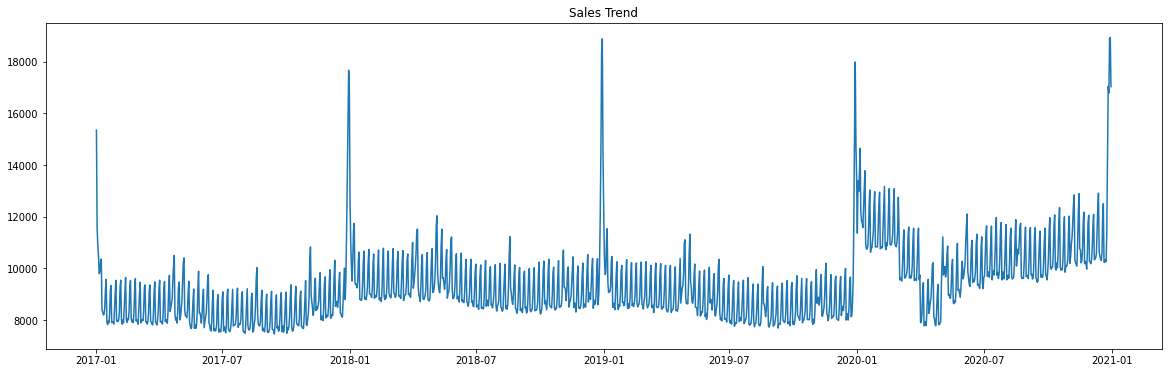

In [31]:
plt.figure(figsize=(20,6))
plt.plot(daily_sales['date'], daily_sales['num_sold'])
plt.title("Sales Trend")
plt.show()


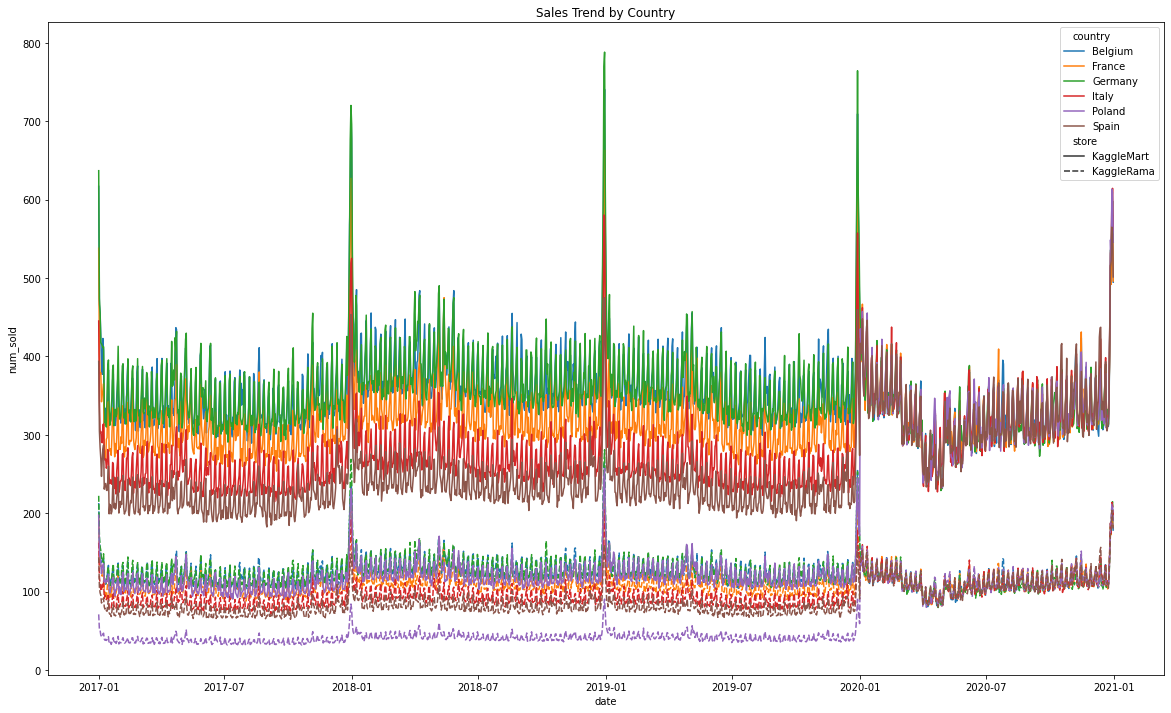

In [32]:
plt.figure(figsize=(20,12))
sns.lineplot(data=train_df,x='date',y='num_sold',hue=train_df.country,style="store",ci=None)
plt.title("Sales Trend by Country")
plt.show()

**Trend by Country**

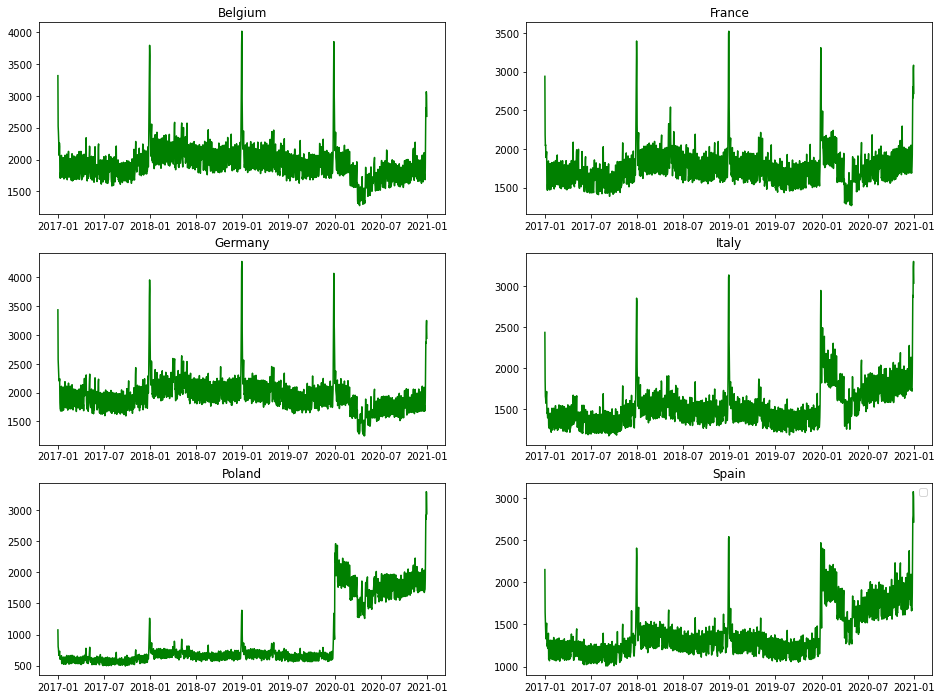

In [33]:
fig, axes = plt.subplots(figsize=(16,12))
for n,country in enumerate(countries):
        plt.subplot(3,2,n+1)
        country_sales = train_df[train_df['country'] == country]
        country_sales_daily = country_sales.groupby('date').sum().reset_index()
        plt.plot(country_sales_daily['date'], country_sales_daily['num_sold'],color='green')
        plt.title(country)

plt.legend()    

plt.show()

In [34]:
daily_sales_by_country = train_df.groupby(['date', 'country']).sum().reset_index().pivot(index='date', columns='country', values='num_sold').reset_index()
daily_sales_by_country.head()

country,date,Belgium,France,Germany,Italy,Poland,Spain
0,2017-01-01,3320,2939,3437,2431,1074,2151
1,2017-01-02,2525,2182,2574,1848,804,1645
2,2017-01-03,2434,2043,2451,1651,774,1531
3,2017-01-04,2301,2053,2281,1625,724,1461
4,2017-01-05,2115,1894,2224,1568,664,1330


In [35]:
country_sales_total = train_df.groupby('country').sum().reset_index().sort_values(by="num_sold")
country_sales_total.head()

,country,num_sold
4,Poland,1341545
5,Spain,2003238
3,Italy,2201092
1,France,2512319
0,Belgium,2781050


<AxesSubplot:xlabel='country', ylabel='num_sold'>

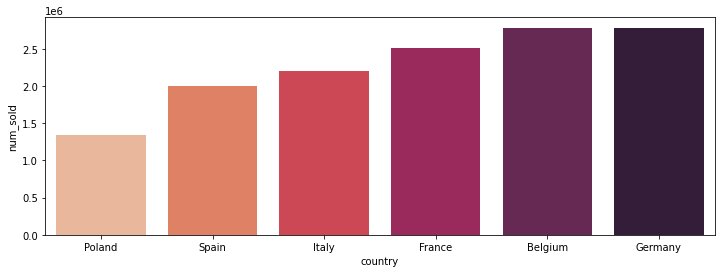

In [36]:
plt.figure(figsize=(12,4))
sns.barplot(data=country_sales_total,x=country_sales_total['country'],y=country_sales_total['num_sold'],palette="rocket_r")

In [37]:
product_sales_by_country = train_df.groupby(['product', 'country']).sum().reset_index().pivot(index='country', columns='product', values='num_sold').reset_index()
product_sales_by_country.head(10)

product,country,Kaggle Advanced Techniques,Kaggle Getting Started,Kaggle Recipe Book,Kaggle for Kids: One Smart Goose
0,Belgium,798840,640927,480174,861109
1,France,722271,578496,432964,778588
2,Germany,800443,641336,481052,863584
3,Italy,633025,506641,379221,682205
4,Poland,384302,308173,230637,418433
5,Spain,575029,461330,345769,621110


In [38]:
store_sales_by_country = train_df.groupby(['store', 'country']).sum().reset_index().pivot(index='country', columns='store', values='num_sold').reset_index()
store_sales_by_country.head(10)

store,country,KaggleMart,KaggleRama
0,Belgium,2064078,716972
1,France,1865517,646802
2,Germany,2068327,718088
3,Italy,1635044,566048
4,Poland,996597,344948
5,Spain,1487691,515547


In [39]:
country_weights = train_df.groupby("country")["num_sold"].sum()/train_df["num_sold"].sum()
country_weights = pd.DataFrame(country_weights).reset_index()
country_weights.rename(columns={'num_sold':'ratio'}, inplace=True)
country_weights.head()

,country,ratio
0,Belgium,0.204104
1,France,0.184381
2,Germany,0.204498
3,Italy,0.161540
4,Poland,0.098457


<AxesSubplot:xlabel='country', ylabel='ratio'>

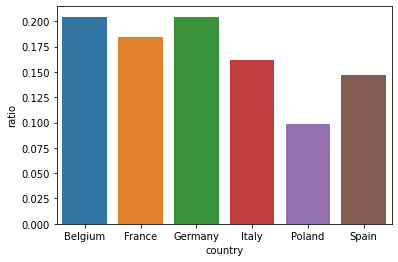

In [40]:
sns.barplot(data=country_weights,x='country',y='ratio')

 **Trend by Stores**

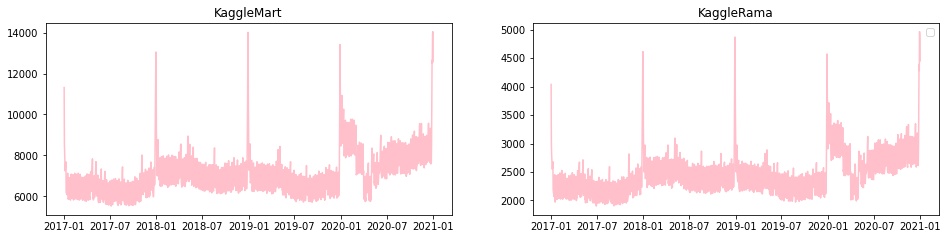

In [41]:
fig, axes = plt.subplots(figsize=(16,12))
for n,store in enumerate(stores):
        plt.subplot(3,2,n+1)
        store_sales = train_df[train_df['store'] == store]
        store_sales_daily = store_sales.groupby('date').sum().reset_index()
        plt.plot(store_sales_daily['date'], store_sales_daily['num_sold'], color='pink')
        plt.title(store)

plt.legend()    

plt.show()

In [42]:
daily_sales_by_store = train_df.groupby(['date', 'store']).sum().reset_index().pivot(index='date', columns='store', values='num_sold').reset_index()

In [43]:
daily_sales_by_store.head()

store,date,KaggleMart,KaggleRama
0,2017-01-01,11314,4038
1,2017-01-02,8564,3014
2,2017-01-03,8074,2810
3,2017-01-04,7736,2709
4,2017-01-05,7244,2551


In [44]:
store_sales_total = train_df.groupby('store').sum().reset_index()

In [45]:
store_sales_total.head()

,store,num_sold
0,KaggleMart,10117254
1,KaggleRama,3508405


<AxesSubplot:xlabel='store', ylabel='num_sold'>

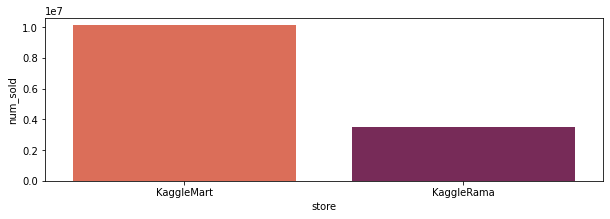

In [46]:
plt.figure(figsize=(10,3))
sns.barplot(data=store_sales_total,x=store_sales_total['store'],y=store_sales_total['num_sold'],palette="rocket_r")

In [47]:
store_weights = train_df.groupby("store")["num_sold"].sum()/train_df["num_sold"].sum()
store_weights = pd.DataFrame(store_weights).reset_index()
store_weights.rename(columns={'num_sold':'ratio'}, inplace=True)
store_weights.head()

,store,ratio
0,KaggleMart,0.742515
1,KaggleRama,0.257485


<AxesSubplot:xlabel='store', ylabel='ratio'>

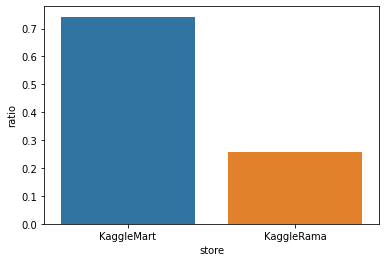

In [48]:
sns.barplot(data=store_weights,x='store',y='ratio')

**Ternd by Product**

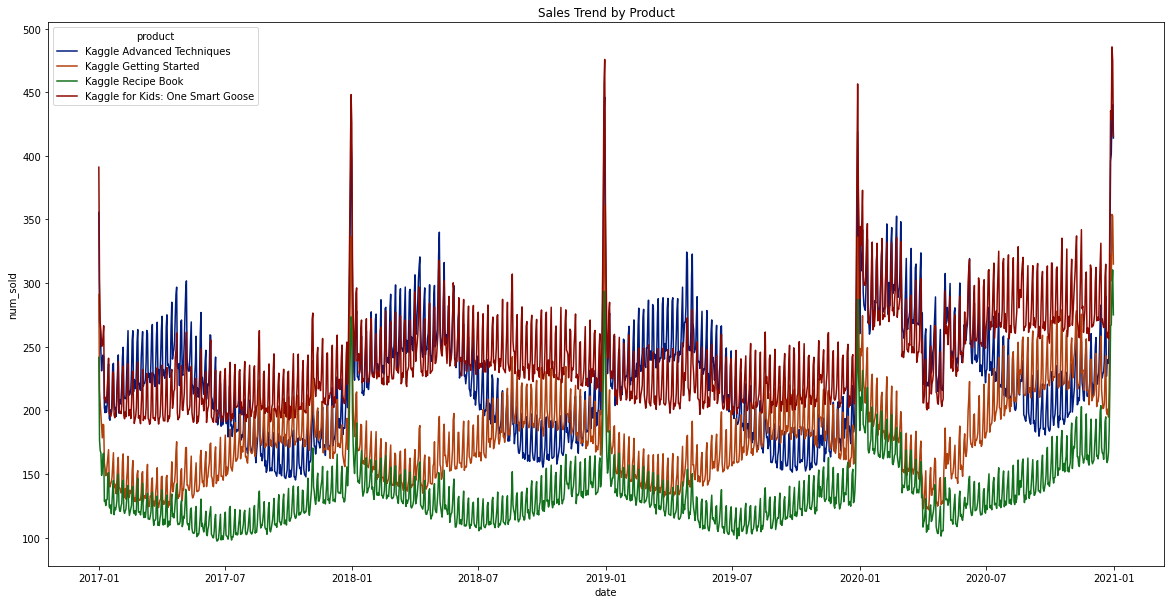

In [49]:
plt.figure(figsize=(20,10))
sns.lineplot(data=train_df,x='date',y='num_sold',hue='product',palette='dark',ci=None)
plt.title("Sales Trend by Product")
plt.show()

In [50]:
product_sales = train_df.groupby(['date', 'product']).sum().reset_index()

In [51]:
product_sales.head()

,date,product,num_sold
0,2017-01-01,Kaggle Advanced Techniques,4267
1,2017-01-01,Kaggle Getting Started,3492
2,2017-01-01,Kaggle Recipe Book,2900
3,2017-01-01,Kaggle for Kids: One Smart Goose,4693
4,2017-01-02,Kaggle Advanced Techniques,3242


In [52]:
product_ratio_daily = product_sales.pivot(index="date", columns="product", values="num_sold")
product_ratio_daily = product_ratio_daily.apply(lambda x: x/x.sum(),axis=1)
product_ratio_daily = product_ratio_daily.stack().rename("ratios").reset_index()

In [53]:
product_ratio_daily.head(4)

,date,product,ratios
0,2017-01-01,Kaggle Advanced Techniques,0.277944
1,2017-01-01,Kaggle Getting Started,0.227462
2,2017-01-01,Kaggle Recipe Book,0.188900
3,2017-01-01,Kaggle for Kids: One Smart Goose,0.305693


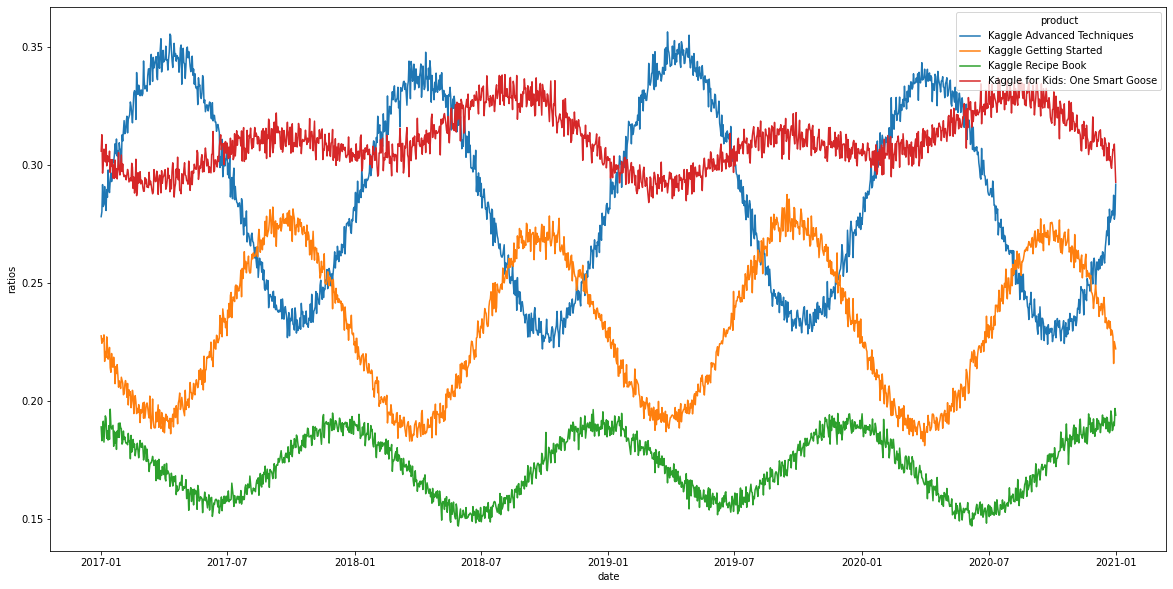

In [54]:
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = product_ratio_daily, x="date", y="ratios", hue="product");

In [55]:
product_sales.head()

,date,product,num_sold
0,2017-01-01,Kaggle Advanced Techniques,4267
1,2017-01-01,Kaggle Getting Started,3492
2,2017-01-01,Kaggle Recipe Book,2900
3,2017-01-01,Kaggle for Kids: One Smart Goose,4693
4,2017-01-02,Kaggle Advanced Techniques,3242


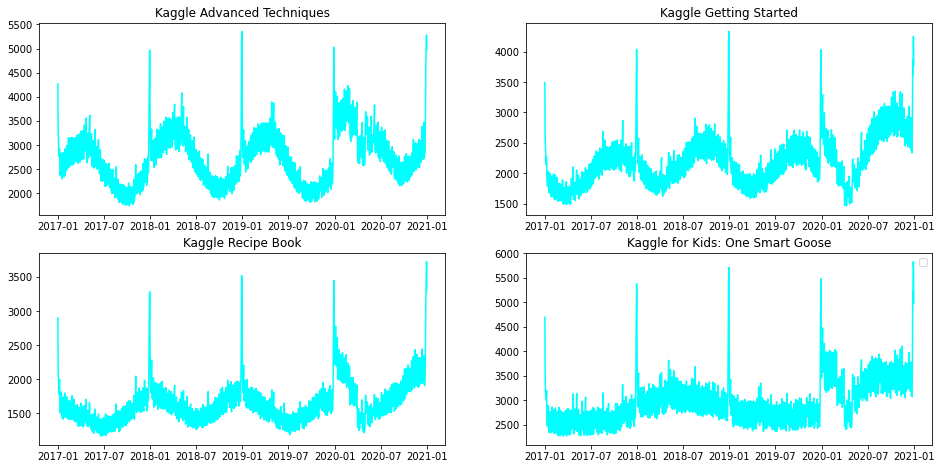

In [56]:
fig, axes = plt.subplots(figsize=(16,12))
for n,product in enumerate(products):
        plt.subplot(3,2,n+1)
        product_sales = train_df[train_df['product'] == product]
        product_sales_daily = product_sales.groupby('date').sum().reset_index()
        plt.plot(product_sales_daily['date'], product_sales_daily['num_sold'], color='cyan')
        plt.title(product)

plt.legend()    

plt.show()

In [57]:
daily_sales_by_product = train_df.groupby(['date', 'product']).sum().reset_index().pivot(index='date', columns='product', values='num_sold').reset_index()

In [58]:
daily_sales_by_product.head()

product,date,Kaggle Advanced Techniques,Kaggle Getting Started,Kaggle Recipe Book,Kaggle for Kids: One Smart Goose
0,2017-01-01,4267,3492,2900,4693
1,2017-01-02,3242,2597,2119,3620
2,2017-01-03,3173,2463,2022,3226
3,2017-01-04,2948,2354,1998,3145
4,2017-01-05,2773,2232,1787,3003


In [59]:
product_sales_total = train_df.groupby('product').sum().reset_index().sort_values(by='num_sold')

In [60]:
product_sales_total.head(10)

,product,num_sold
2,Kaggle Recipe Book,2349817
1,Kaggle Getting Started,3136903
0,Kaggle Advanced Techniques,3913910
3,Kaggle for Kids: One Smart Goose,4225029


<AxesSubplot:xlabel='product', ylabel='num_sold'>

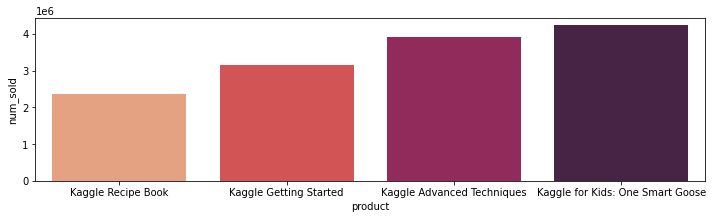

In [61]:
plt.figure(figsize=(12,3))
sns.barplot(data=product_sales_total,x=product_sales_total['product'],y=product_sales_total['num_sold'],palette="rocket_r")

In [62]:
product_weights = train_df.groupby("product")["num_sold"].sum()/train_df["num_sold"].sum()
product_weights = pd.DataFrame(product_weights).reset_index()
product_weights.rename(columns={'num_sold':'ratio'}, inplace=True)
product_weights.head()

,product,ratio
0,Kaggle Advanced Techniques,0.287246
1,Kaggle Getting Started,0.230220
2,Kaggle Recipe Book,0.172455
3,Kaggle for Kids: One Smart Goose,0.310079


<AxesSubplot:xlabel='product', ylabel='ratio'>

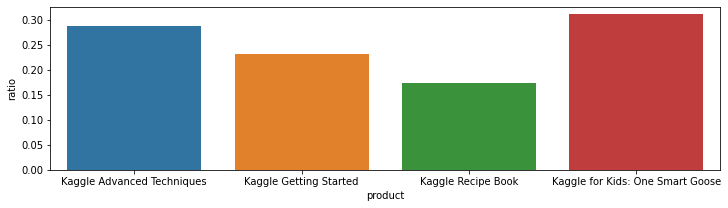

In [63]:
plt.figure(figsize=(12,3))
sns.barplot(data=product_weights,x='product',y='ratio')

# **WEEKLY SALES**

In [64]:
weekly_sales = train_df.groupby(["country","store", "product", pd.Grouper(key="date", freq="W")])["num_sold"].sum().rename("num_sold").reset_index()

In [65]:
weekly_sales.head()

,country,store,product,date,num_sold
0,Belgium,KaggleMart,Kaggle Advanced Techniques,2017-01-01,663
1,Belgium,KaggleMart,Kaggle Advanced Techniques,2017-01-08,3362
2,Belgium,KaggleMart,Kaggle Advanced Techniques,2017-01-15,2757
3,Belgium,KaggleMart,Kaggle Advanced Techniques,2017-01-22,2863
4,Belgium,KaggleMart,Kaggle Advanced Techniques,2017-01-29,2924


Text(0.5, 1.0, 'Weeky Sales')

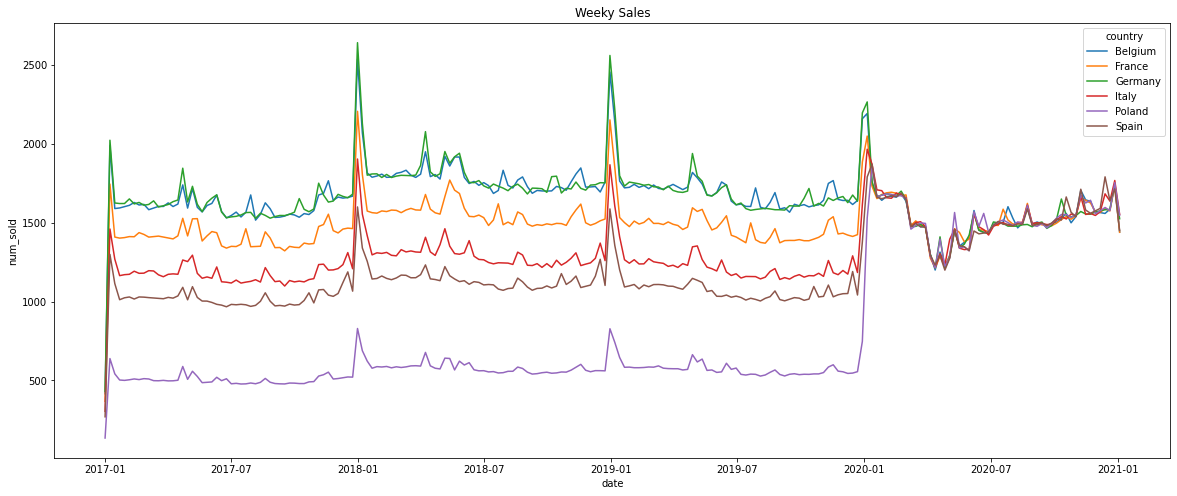

In [66]:
plt.figure(figsize=(20,8))
sns.lineplot(data=weekly_sales, x=weekly_sales.date, y=weekly_sales.num_sold,hue=weekly_sales.country,ci=None)
plt.title('Weeky Sales')

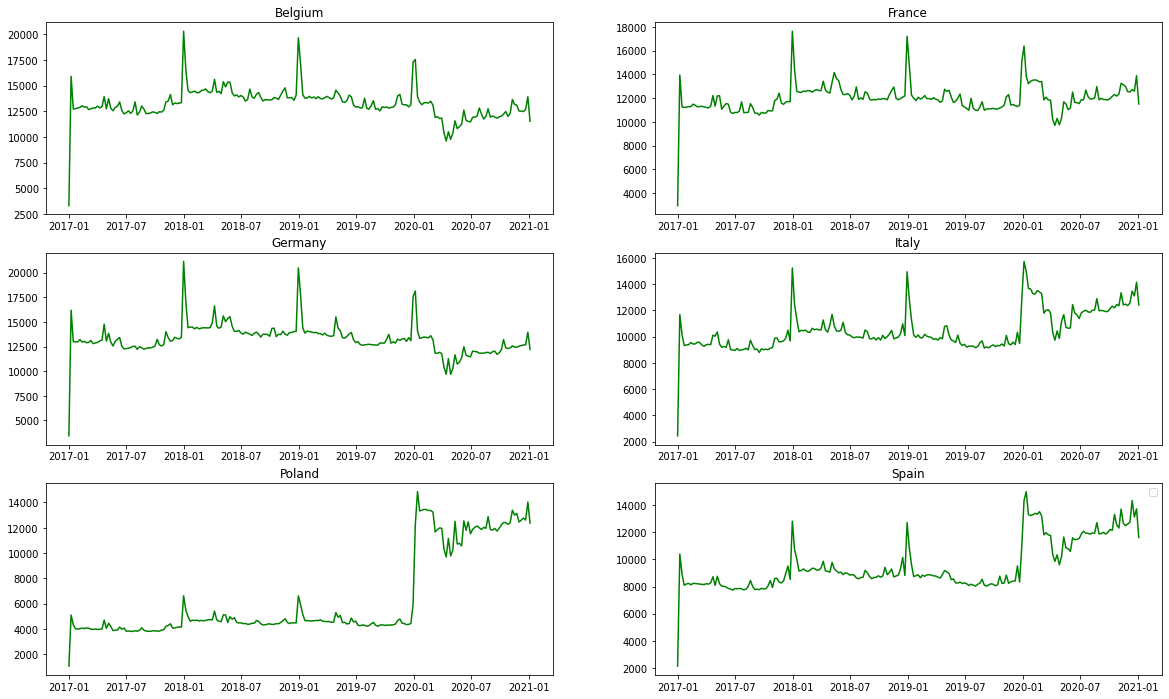

In [67]:
fig, axes = plt.subplots(figsize=(20,12))
for n,country in enumerate(countries):
        plt.subplot(3,2,n+1)
        country_sales_Weekly = weekly_sales[weekly_sales['country'] == country]
        country_sales_Weekly = country_sales_Weekly.groupby('date').sum().reset_index()
        plt.plot(country_sales_Weekly['date'], country_sales_Weekly['num_sold'],color='green')
        plt.title(country)

plt.legend()    
plt.show()

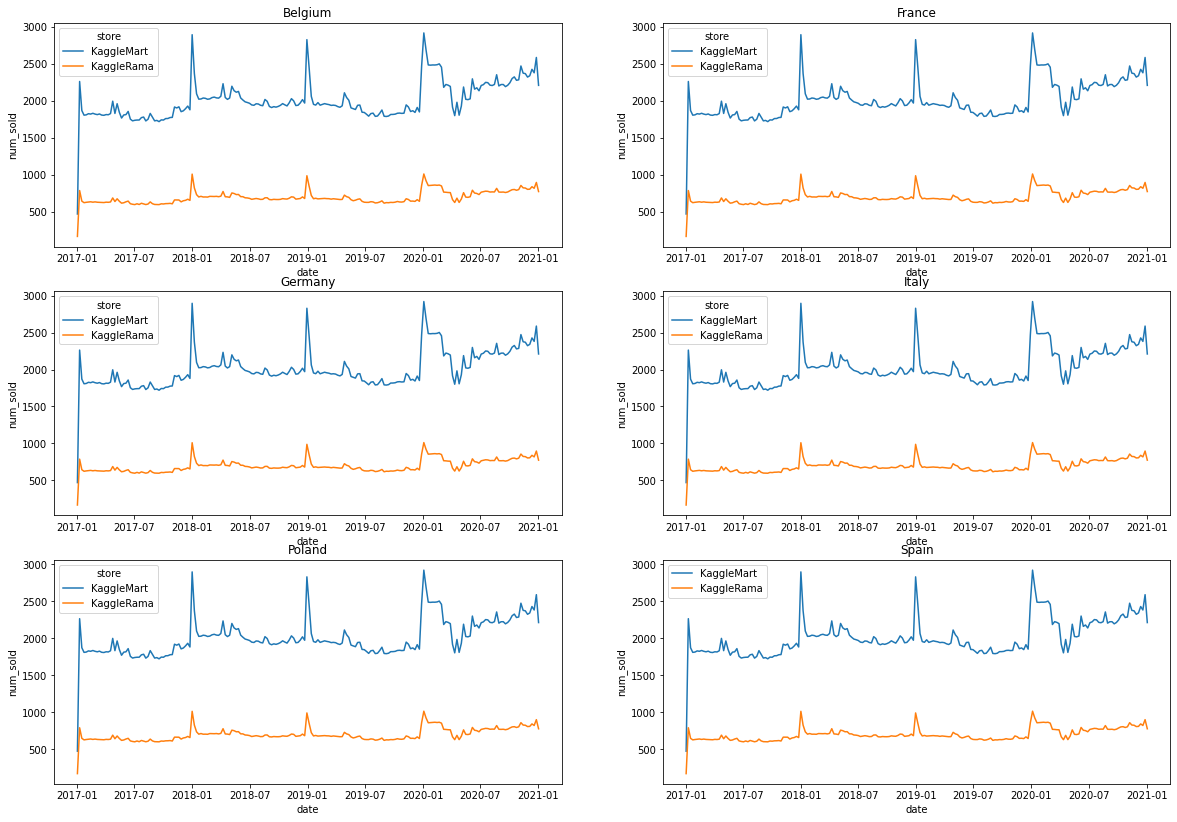

In [68]:
fig, axes = plt.subplots(figsize=(20,14))
for n,country in enumerate(countries):
        plt.subplot(3,2,n+1)
        country_sales_Weekly = weekly_sales[weekly_sales['country'] == country]
        country_sales_Weekly = country_sales_Weekly.groupby('date').sum().reset_index()
        sns.lineplot(data=weekly_sales, x=weekly_sales.date, y=weekly_sales.num_sold,hue=weekly_sales.store,ci=None)
        plt.title(country)

plt.legend()    
plt.show()

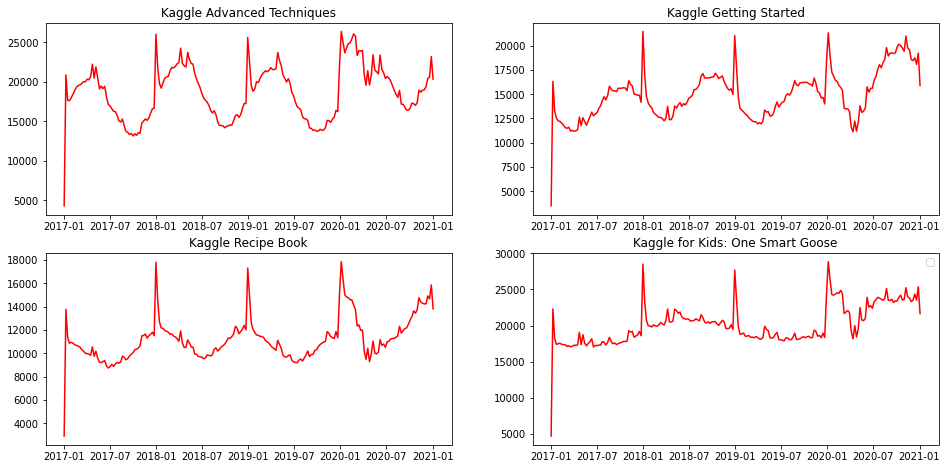

In [69]:
fig, axes = plt.subplots(figsize=(16,12))
for n,product in enumerate(products):
        plt.subplot(3,2,n+1)
        product_sales_Weekly = weekly_sales[weekly_sales['product'] == product]
        product_sales_Weekly = product_sales_Weekly.groupby('date').sum().reset_index()
        plt.plot(product_sales_Weekly['date'], product_sales_Weekly['num_sold'],color='red')
        plt.title(product)

plt.legend()    
plt.show()

# **Monthly**

In [70]:
monthly_sales = train_df.groupby(["country","store", "product", pd.Grouper(key="date", freq="MS")])["num_sold"].sum().rename("num_sold").reset_index()

In [71]:
monthly_sales.head(10)

,country,store,product,date,num_sold
0,Belgium,KaggleMart,Kaggle Advanced Techniques,2017-01-01,13345
1,Belgium,KaggleMart,Kaggle Advanced Techniques,2017-02-01,12556
2,Belgium,KaggleMart,Kaggle Advanced Techniques,2017-03-01,14137
3,Belgium,KaggleMart,Kaggle Advanced Techniques,2017-04-01,14575
4,Belgium,KaggleMart,Kaggle Advanced Techniques,2017-05-01,14338
5,Belgium,KaggleMart,Kaggle Advanced Techniques,2017-06-01,12716
6,Belgium,KaggleMart,Kaggle Advanced Techniques,2017-07-01,12084
7,Belgium,KaggleMart,Kaggle Advanced Techniques,2017-08-01,10574
8,Belgium,KaggleMart,Kaggle Advanced Techniques,2017-09-01,9314
9,Belgium,KaggleMart,Kaggle Advanced Techniques,2017-10-01,9501


Text(0.5, 1.0, 'Weeky Sales ')

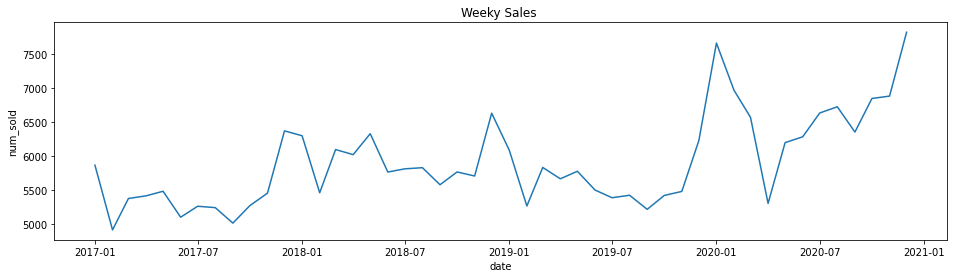

In [72]:
plt.figure(figsize=(16,4))
sns.lineplot(data=monthly_sales, x='date', y='num_sold',ci=None)
plt.title('Weeky Sales ')

Text(0.5, 1.0, 'Weeky Sales')

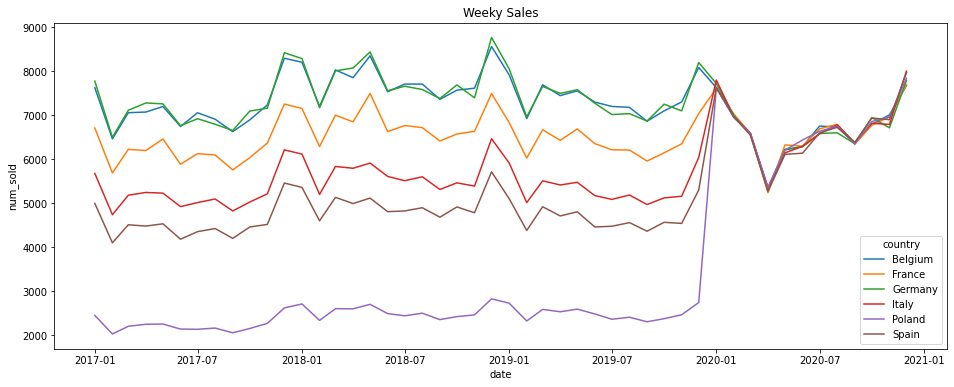

In [73]:
plt.figure(figsize=(16,6))
sns.lineplot(data=monthly_sales, x='date', y='num_sold',hue='country',ci=None)
plt.title('Weeky Sales')

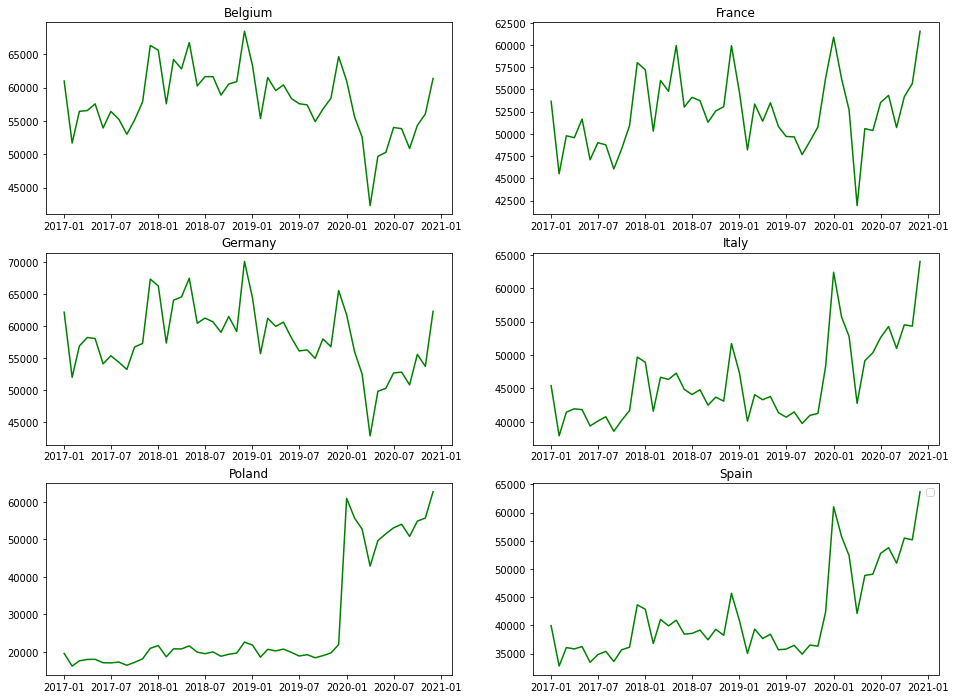

In [74]:
fig, axes = plt.subplots(figsize=(16,12))
for n,country in enumerate(countries):
        plt.subplot(3,2,n+1)
        country_sales_monthly = monthly_sales[monthly_sales['country'] == country]
        country_sales_monthly = country_sales_monthly.groupby('date').sum().reset_index()
        plt.plot(country_sales_monthly['date'], country_sales_monthly['num_sold'],color='green')
        plt.title(country)

plt.legend()    
plt.show()

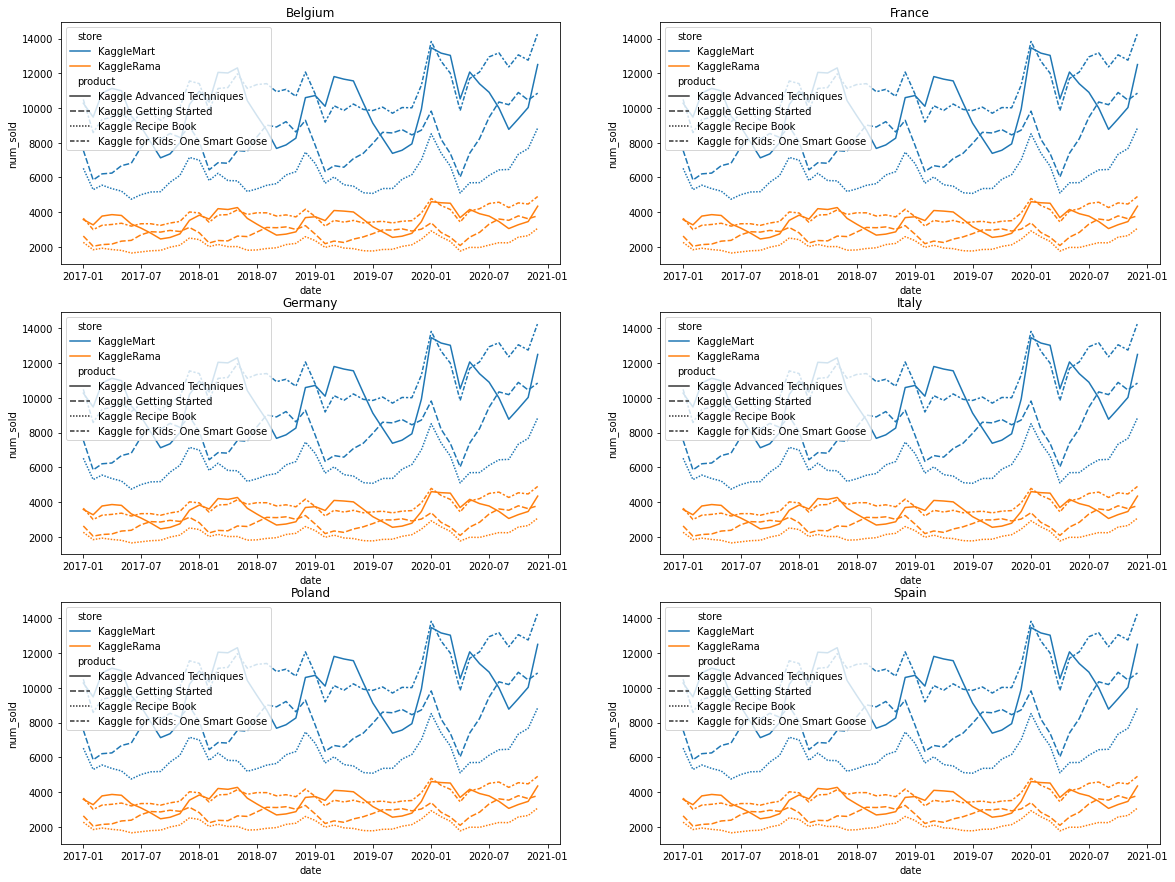

In [75]:
fig, axes = plt.subplots(figsize=(16,12))
fig.tight_layout()

for n,country in enumerate(countries):
        plt.subplot(3,2,n+1)
        country_sales_monthly = monthly_sales[monthly_sales['country'] == country]
        country_sales_monthly = country_sales_monthly.groupby('date').sum().reset_index()
        sns.lineplot(data=monthly_sales, x="date", y='num_sold',hue='store',style='product',ci=None)
        plt.title(country)

plt.legend()    
plt.show()

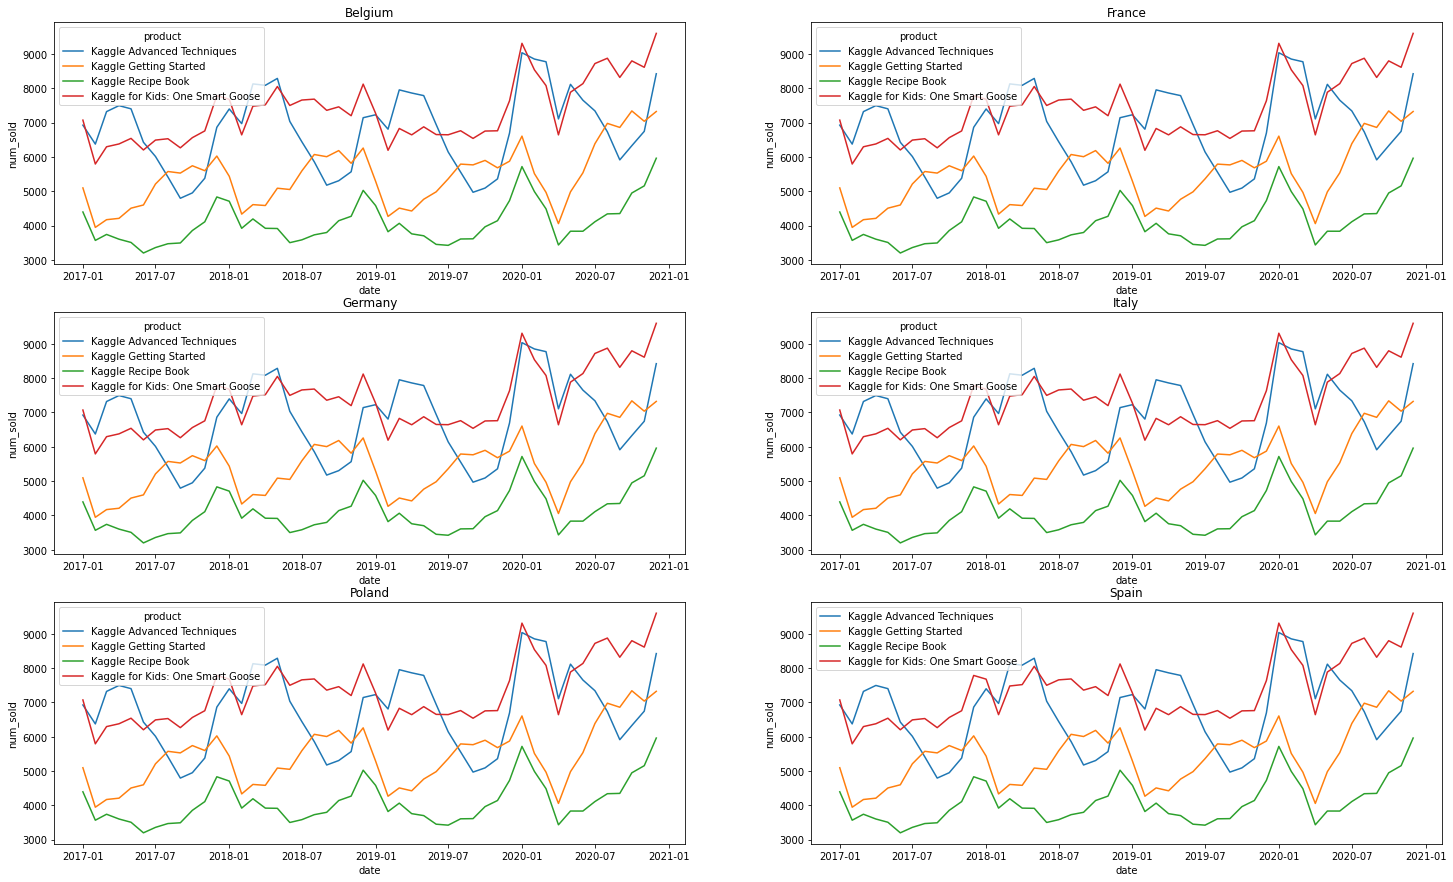

In [76]:
fig, axes = plt.subplots(figsize=(20,12))
fig.tight_layout()

for n,country in enumerate(countries):
        plt.subplot(3,2,n+1)
        country_sales_monthly = monthly_sales[monthly_sales['country'] == country]
        country_sales_monthly = country_sales_monthly.groupby('date').sum().reset_index()
        sns.lineplot(data=monthly_sales, x="date", y='num_sold',hue='product',ci=None)
        plt.title(country)

plt.legend()    
plt.show()

# Head Lines Form EDA:
1 - Each Product has Identical Behavior in sales Trends and this behavior is almost the same in all countries

2 - Regarding Stores, the pattern is the same but KaggleMart Volume Sales are almost 3 time Bigger Than Kaggle Rama

3 - From 2017 to 2019 each country has its own volume of sales  and from Jan 2020 VolueSale is almost Equal for All countries

4 - in 2020 we can see  significant growth in all the countries

5 - The most Number Sold is in Germany and the Poland is least.

6 - Product Sales orders Are: Kaggle Recipe Book, Kaggle Recipe Book, Kaggle Advanced Techniques, Kaggle for Kids: One Smart Goose

7 - Minimus Sales on Specific days for a particular Product in a specific Store is 19 and the max is 986.

8 - There is not any Null value in train and test Data, So No need to Imputation the Data

9 - It Seems Seasonal Pattern all around Data.

10 - We need to Exclude March to May 2020 due to abnormality pattern 

# **PreProccess**

In [77]:
extended_train = train_df.copy()

In [78]:
extended_train = extended_train.groupby(["date"])["num_sold"].sum().reset_index()

In [79]:
extended_train["day"] = extended_train["date"].dt.day
extended_train["month"] = extended_train["date"].dt.month
extended_train['year'] = extended_train['date'].dt.year
extended_train["day_of_week"] = extended_train["date"].dt.dayofweek
extended_train["day_of_year"] = extended_train["date"].dt.dayofyear
extended_train['week_number'] = extended_train['date'].dt.week
extended_train['is_weekend'] = np.where(extended_train['day_of_week'].isin([5,6]),1,0)
extended_train.head(10)

,date,num_sold,day,month,year,day_of_week,day_of_year,week_number,is_weekend
0,2017-01-01,15352,1,1,2017,6,1,52,1
1,2017-01-02,11578,2,1,2017,0,2,1,0
2,2017-01-03,10884,3,1,2017,1,3,1,0
3,2017-01-04,10445,4,1,2017,2,4,1,0
4,2017-01-05,9795,5,1,2017,3,5,1,0
5,2017-01-06,9883,6,1,2017,4,6,1,0
6,2017-01-07,10271,7,1,2017,5,7,1,1
7,2017-01-08,10365,8,1,2017,6,8,1,1
8,2017-01-09,8378,9,1,2017,0,9,2,0
9,2017-01-10,8314,10,1,2017,1,10,2,0


In [80]:
extended_test = test_df.copy()

In [81]:
extended_test.head()

,date,country,store,product
row_id,,,,
70128,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques
70129,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started
70130,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book
70131,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose
70132,2021-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques


In [82]:
extended_test = test_df.groupby(["date"])["store"].first().reset_index()
extended_test = extended_test.drop('store', axis=1)

In [83]:
extended_test.head()

,date
0,2021-01-01
1,2021-01-02
2,2021-01-03
3,2021-01-04
4,2021-01-05


In [84]:
all_test_dates  = extended_test.copy()
all_test_dates.head()

,date
0,2021-01-01
1,2021-01-02
2,2021-01-03
3,2021-01-04
4,2021-01-05


In [85]:
extended_test["day"] = extended_test["date"].dt.day
extended_test["month"] = extended_test["date"].dt.month
extended_test['year'] = extended_test['date'].dt.year
extended_test["day_of_week"] = extended_test["date"].dt.dayofweek
extended_test["day_of_year"] = extended_test["date"].dt.dayofyear
extended_test['week_number'] = extended_test['date'].dt.week
extended_test['is_weekend'] = np.where(extended_test['day_of_week'].isin([5,6]),1,0)
extended_test.head(10)

,date,day,month,year,day_of_week,day_of_year,week_number,is_weekend
0,2021-01-01,1,1,2021,4,1,53,0
1,2021-01-02,2,1,2021,5,2,53,1
2,2021-01-03,3,1,2021,6,3,53,1
3,2021-01-04,4,1,2021,0,4,1,0
4,2021-01-05,5,1,2021,1,5,1,0
5,2021-01-06,6,1,2021,2,6,1,0
6,2021-01-07,7,1,2021,3,7,1,0
7,2021-01-08,8,1,2021,4,8,1,0
8,2021-01-09,9,1,2021,5,9,1,1
9,2021-01-10,10,1,2021,6,10,1,1


Text(0.5, 1.0, 'Saily Sales Distribution')

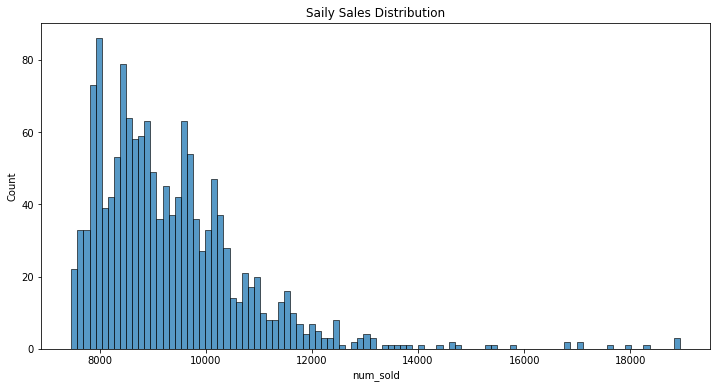

In [86]:
fig, axes = plt.subplots(figsize=(12,6))
sns.histplot(data=extended_train, x="num_sold",bins=100)
plt.title("Saily Sales Distribution")

Text(0.5, 1.0, 'Sales Distribition on each day of month')

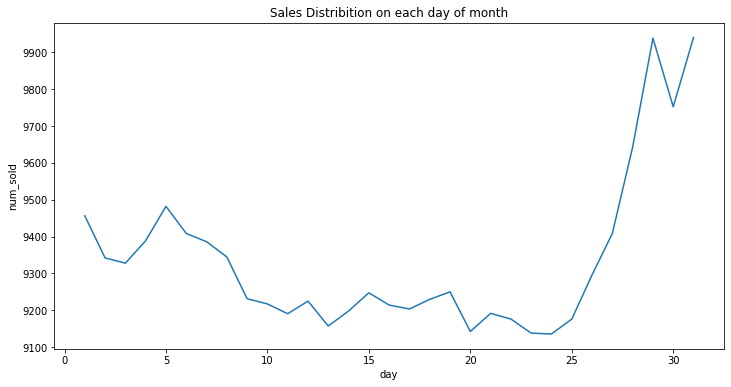

In [87]:
fig, axes = plt.subplots(figsize=(12,6))
sns.lineplot(data=extended_train, x='day', y="num_sold",ci=None)
plt.title("Sales Distribition on each day of month")

Text(0.5, 1.0, 'Sale Distribition  Moths')

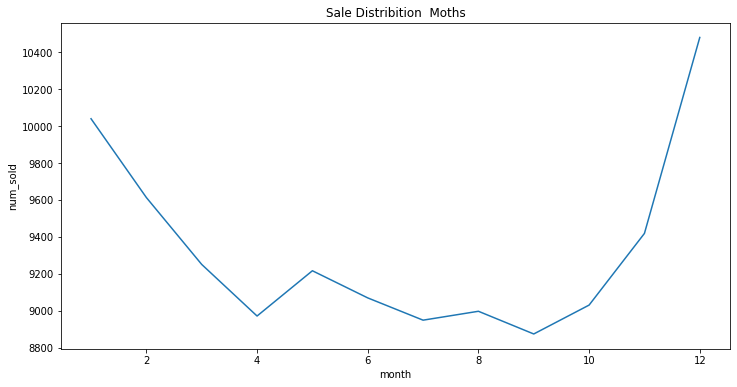

In [88]:
fig, axes = plt.subplots(figsize=(12,6))
sns.lineplot(data=extended_train, x='month', y="num_sold",ci=None)
plt.title("Sale Distribition  Moths")

<AxesSubplot:xlabel='year', ylabel='num_sold'>

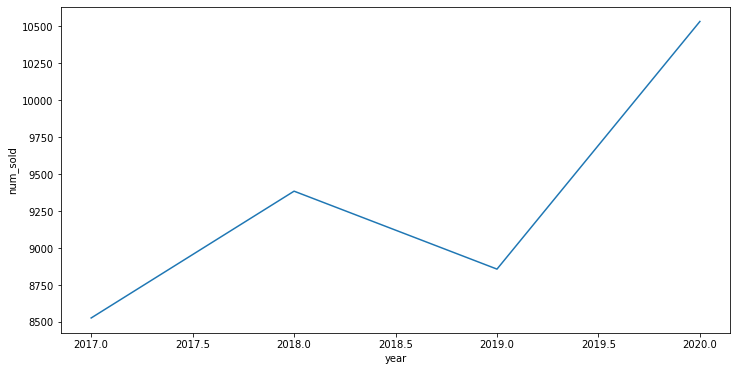

In [89]:
fig, axes = plt.subplots(figsize=(12,6))
sns.lineplot(data=extended_train, x='year', y="num_sold",ci=None)

Text(0.5, 1.0, '2020 Monthly Sales Trend')

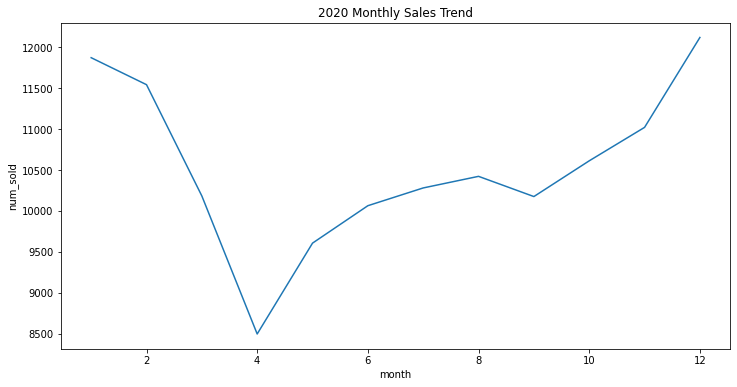

In [90]:
# Abnormality Detected IN 2020
fig, axes = plt.subplots(figsize=(12,6))
sns.lineplot(data=extended_train[extended_train['year']==2020], x=extended_train['month'], y="num_sold",ci=None)
plt.title("2020 Monthly Sales Trend")

In [91]:
# Romove Abnormal Pattern From Train DataSet 
extended_train = extended_train[~((extended_train['year']== 2020) & (extended_train['month'].isin([3,4,5])))]

In [92]:
# Change 31 December 2020 to  1 Jan 2021
extended_train["day_of_year"] = extended_train.apply(lambda x: x["day_of_year"]-1 if (x["date"] > pd.Timestamp("2020-02-29") and x["date"] < pd.Timestamp("2021-01-01"))  else x["day_of_year"], axis=1)

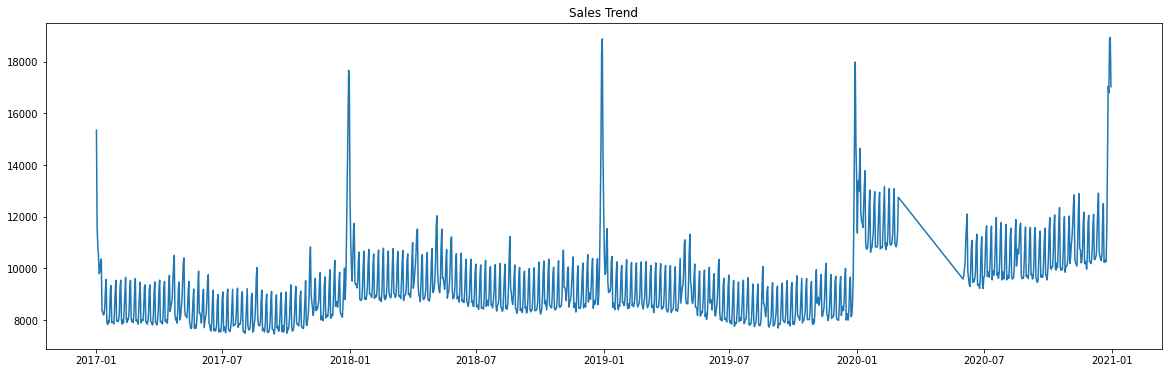

In [93]:
plt.figure(figsize=(20,6))
plt.plot(extended_train['date'], extended_train['num_sold'])
plt.title("Sales Trend")
plt.show()

<AxesSubplot:xlabel='day_of_week', ylabel='num_sold'>

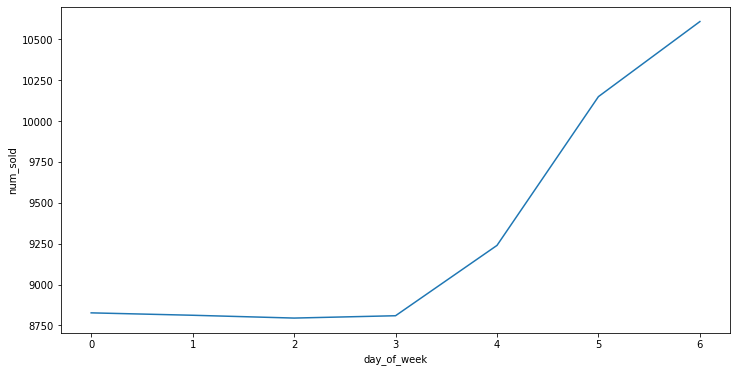

In [94]:
fig, axes = plt.subplots(figsize=(12,6))
sns.lineplot(data=extended_train, x='day_of_week', y="num_sold",ci=None)

<AxesSubplot:xlabel='week_number', ylabel='num_sold'>

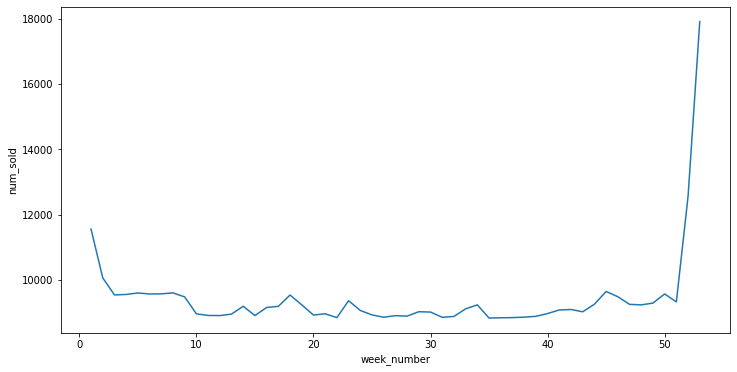

In [95]:
fig, axes = plt.subplots(figsize=(12,6))
sns.lineplot(data=extended_train, x='week_number', y="num_sold",ci=None)

<AxesSubplot:xlabel='day_of_year', ylabel='num_sold'>

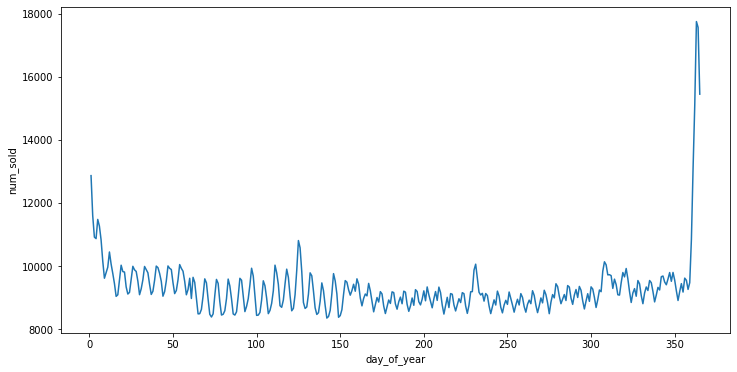

In [96]:
fig, axes = plt.subplots(figsize=(12,6))
sns.lineplot(data=extended_train, x='day_of_year', y="num_sold",ci=None)

In [97]:
daily_sales_extended = extended_train[['day_of_year','num_sold']]
daily_sales_extended = daily_sales_extended.groupby('day_of_year').sum().sort_values(by='num_sold',ascending=False).reset_index()
daily_sales_extended.head(20)

,day_of_year,num_sold
0,363,71004
1,364,70258
2,365,61797
3,362,60401
4,361,52424
5,1,51466
6,2,46393
7,5,45914
8,6,45069
9,3,43669


In [98]:
important_days = daily_sales_extended['day_of_year'][:50].to_list()
print(important_days,end='')

[363, 364, 365, 362, 361, 1, 2, 5, 6, 3, 4, 360, 7, 12, 8, 308, 13, 231, 54, 309, 19, 47, 40, 26, 33, 11, 41, 48, 55, 321, 49, 34, 27, 230, 307, 56, 28, 20, 21, 349, 319, 10, 347, 35, 42, 14, 311, 310, 312, 343]

In [99]:
extended_train['important_day'] = extended_train["day_of_year"].apply(lambda x: x if x in important_days else 0)
extended_test['important_day'] = extended_test["day_of_year"].apply(lambda x: x if x in important_days else 0)

In [100]:
# Convet week 53 2020 to Week1 2021
extended_test['week_number'] = np.where(extended_test['week_number']==53, 1, extended_test['week_number'])

In [101]:
extended_train["month_sin"] = np.sin(extended_train['month'] * (2 * np.pi / 12))
extended_test["month_sin"] = np.sin(extended_test['month'] * (2 * np.pi / 12))

In [102]:
extended_train = pd.get_dummies(extended_train, columns = ["important_day","day_of_week"], drop_first=True)
extended_test = pd.get_dummies(extended_test, columns = ["important_day","day_of_week"], drop_first=True)

In [103]:
extended_train.head()

,date,num_sold,day,month,year,day_of_year,week_number,is_weekend,month_sin,important_day_1,...,important_day_362,important_day_363,important_day_364,important_day_365,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,2017-01-01,15352,1,1,2017,1,52,1,0.5,1,...,0,0,0,0,0,0,0,0,0,1
1,2017-01-02,11578,2,1,2017,2,1,0,0.5,0,...,0,0,0,0,0,0,0,0,0,0
2,2017-01-03,10884,3,1,2017,3,1,0,0.5,0,...,0,0,0,0,1,0,0,0,0,0
3,2017-01-04,10445,4,1,2017,4,1,0,0.5,0,...,0,0,0,0,0,1,0,0,0,0
4,2017-01-05,9795,5,1,2017,5,1,0,0.5,0,...,0,0,0,0,0,0,1,0,0,0


In [104]:

extended_test.head()

,date,day,month,year,day_of_year,week_number,is_weekend,month_sin,important_day_1,important_day_2,...,important_day_362,important_day_363,important_day_364,important_day_365,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
0,2021-01-01,1,1,2021,1,1,0,0.5,1,0,...,0,0,0,0,0,0,0,1,0,0
1,2021-01-02,2,1,2021,2,1,1,0.5,0,1,...,0,0,0,0,0,0,0,0,1,0
2,2021-01-03,3,1,2021,3,1,1,0.5,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2021-01-04,4,1,2021,4,1,0,0.5,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2021-01-05,5,1,2021,5,1,0,0.5,0,0,...,0,0,0,0,1,0,0,0,0,0


# Ridge

In [105]:
y = extended_train['num_sold']
X = extended_train.drop(['date','month','num_sold','week_number',"is_weekend"],axis=1)
X_test = extended_test.drop(['date','month', 'week_number',"is_weekend"],axis=1)


In [106]:
all_test_dates.head()

,date
0,2021-01-01
1,2021-01-02
2,2021-01-03
3,2021-01-04
4,2021-01-05


In [107]:
preds_lst = []
kf = GroupKFold(n_splits=4)
scores = []
weights = [45, 55, 53, 45]
for fold, (train_idx, val_idx) in enumerate(kf.split(X, groups=X.year)):
    model = Ridge(alpha=0.2, tol=0.00001, max_iter=10000)
    model = make_pipeline(StandardScaler(), model)
    model.fit(X.iloc[train_idx], y.iloc[train_idx])
    preds_lst.append(model.predict(X_test)* weights[fold])
    sc =  model.score(X.iloc[val_idx], y.iloc[val_idx])
    scores.append(sc)
    print(fold, X.iloc[train_idx]['year'].unique(),  X.iloc[val_idx]['year'].unique(), sc)
print("Mean score", np.mean(scores))
preds_df = pd.DataFrame(np.column_stack(preds_lst))
#average predictions from kfold
preds_df['num_sold'] = preds_df.sum(axis = 1)/np.sum(weights)
all_test_dates["num_sold"] = preds_df['num_sold']

0 [2017 2018 2020] [2019] -0.5409715226604135
1 [2017 2019 2020] [2018] 0.756884670047639
2 [2018 2019 2020] [2017] 0.8527067045266387
3 [2017 2018 2019] [2020] -0.5691004324625679
Mean score 0.1248798548628241


In [108]:
all_test_dates.head()

,date,num_sold
0,2021-01-01,14253.533756
1,2021-01-02,14321.816265
2,2021-01-03,13965.787678
3,2021-01-04,11856.528410
4,2021-01-05,12035.430764


In [109]:
product_ratio_daily_19 = product_ratio_daily.loc[product_ratio_daily["date"].dt.year == 2019].copy()
product_ratio_daily_19["mm-dd"] = product_ratio_daily_19["date"].dt.strftime('%m-%d')
product_ratio_daily_19 = product_ratio_daily_19.drop(columns="date")
product_ratio_daily_19.head()

,product,ratios,mm-dd
2920,Kaggle Advanced Techniques,0.279273,01-01
2921,Kaggle Getting Started,0.230832,01-01
2922,Kaggle Recipe Book,0.188119,01-01
2923,Kaggle for Kids: One Smart Goose,0.301776,01-01
2924,Kaggle Advanced Techniques,0.281654,01-02


In [110]:
test_df_product_ratio = test_df.copy()
test_df_product_ratio['mm-dd'] = test_df_product_ratio['date'].dt.strftime("%m-%d")
test_df_product_ratio.head()

,date,country,store,product,mm-dd
row_id,,,,,
70128,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,01-01
70129,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started,01-01
70130,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book,01-01
70131,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,01-01
70132,2021-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,01-01


In [111]:
test_df_product_ratio = pd.merge(test_df_product_ratio,product_ratio_daily_19,how='left',on=['mm-dd','product'])

In [112]:
sub_df = pd.merge(test_df,all_test_dates,how='left')
sub_df['ratios'] = test_df_product_ratio['ratios']
sub_df.head(10)

,date,country,store,product,num_sold,ratios
0,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,14253.533756,0.279273
1,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started,14253.533756,0.230832
2,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book,14253.533756,0.188119
3,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,14253.533756,0.301776
4,2021-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,14253.533756,0.279273
5,2021-01-01,Belgium,KaggleRama,Kaggle Getting Started,14253.533756,0.230832
6,2021-01-01,Belgium,KaggleRama,Kaggle Recipe Book,14253.533756,0.188119
7,2021-01-01,Belgium,KaggleRama,Kaggle for Kids: One Smart Goose,14253.533756,0.301776
8,2021-01-01,France,KaggleMart,Kaggle Advanced Techniques,14253.533756,0.279273
9,2021-01-01,France,KaggleMart,Kaggle Getting Started,14253.533756,0.230832


Since 2020 Country Sales almost the same we will consider balanced distribution between them but regarding store even in 2020 kaggleMart Has Bigger Sales Volume

In [113]:
store_weights = train_df.groupby("store")["num_sold"].sum()/train_df["num_sold"].sum()
store_weights

store
KaggleMart    0.742515
KaggleRama    0.257485
Name: num_sold, dtype: float64

In [114]:
country_balanced = pd.Series(index=sub_df['country'].unique(),data =1/6)
country_balanced

Belgium    0.166667
France     0.166667
Germany    0.166667
Italy      0.166667
Poland     0.166667
Spain      0.166667
dtype: float64

In [115]:
for country in country_balanced.index:
        sub_df.loc[(sub_df["country"] == country), "num_sold"] = sub_df.loc[(sub_df["country"] == country), "num_sold"] *  country_balanced[country]
sub_df.head()

,date,country,store,product,num_sold,ratios
0,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,2375.588959,0.279273
1,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started,2375.588959,0.230832
2,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book,2375.588959,0.188119
3,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,2375.588959,0.301776
4,2021-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,2375.588959,0.279273


In [116]:
for store in store_weights.index:
        sub_df.loc[sub_df["store"] == store, "num_sold"] = sub_df.loc[sub_df["store"] == store, "num_sold"] * store_weights[store]
sub_df.head()

,date,country,store,product,num_sold,ratios
0,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,1763.910054,0.279273
1,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started,1763.910054,0.230832
2,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book,1763.910054,0.188119
3,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,1763.910054,0.301776
4,2021-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,611.678905,0.279273


In [117]:
sub_df['num_sold'] = sub_df['num_sold'] * sub_df['ratios']
sub_df['num_sold'] = sub_df['num_sold'].round()
sub_df.head()

,date,country,store,product,num_sold,ratios
0,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,493.0,0.279273
1,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started,407.0,0.230832
2,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book,332.0,0.188119
3,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,532.0,0.301776
4,2021-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,171.0,0.279273


In [118]:
final_submission = pd.read_csv("../input/tabular-playground-series-sep-2022/sample_submission.csv")
final_submission.head()

,row_id,num_sold
0,70128,100
1,70129,100
2,70130,100
3,70131,100
4,70132,100


In [119]:
final_submission['num_sold'] =sub_df['num_sold']
final_submission.head()

,row_id,num_sold
0,70128,493.0
1,70129,407.0
2,70130,332.0
3,70131,532.0
4,70132,171.0


In [120]:
final_submission.to_csv('submission_rigid.csv',index=False)

In [121]:
models = pd.DataFrame()
models['Ridge'] = sub_df['num_sold']
models.head()

,Ridge
0,493.0
1,407.0
2,332.0
3,532.0
4,171.0


# LASSO

In [122]:
y = extended_train['num_sold']
X = extended_train.drop(['date','month','num_sold','week_number'],axis=1)
X_test = extended_test.drop(['date','month', 'week_number'],axis=1)

In [123]:
all_test_dates.drop('num_sold',axis=1,inplace=True)
all_test_dates.head()

,date
0,2021-01-01
1,2021-01-02
2,2021-01-03
3,2021-01-04
4,2021-01-05


In [124]:
preds_lst = []
kf = GroupKFold(n_splits=4)
scores = []
params = {'alpha':[0.1, 0.2, 0.3, 0.4, 0.5],'solver':('auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga') }
for fold, (train_idx, val_idx) in enumerate(kf.split(X, groups=X.year)):
    model = Lasso(tol=0.00002,max_iter=10000,alpha=0.2)
    model = make_pipeline(StandardScaler(), model)
    model.fit(X.iloc[train_idx], y.iloc[train_idx])
    preds_lst.append(model.predict(X_test)* weights[fold])
    sc =  model.score(X.iloc[val_idx], y.iloc[val_idx])
    scores.append(sc)
    print(fold, X.iloc[train_idx]['year'].unique(),  X.iloc[val_idx]['year'].unique(), sc)
print("Mean score", np.mean(scores))
preds_df = pd.DataFrame(np.column_stack(preds_lst))
#average predictions from kfold
preds_df['num_sold'] = preds_df.sum(axis = 1)/np.sum(weights)
all_test_dates["num_sold"] = preds_df['num_sold']

0 [2017 2018 2020] [2019] -0.5409313486899952
1 [2017 2019 2020] [2018] 0.757346669561777
2 [2018 2019 2020] [2017] 0.8526221688921695
3 [2017 2018 2019] [2020] -0.5700006169758258
Mean score 0.1247592181970314


In [125]:
all_test_dates.head()

,date,num_sold
0,2021-01-01,14250.034653
1,2021-01-02,14319.121544
2,2021-01-03,13962.811885
3,2021-01-04,11854.159014
4,2021-01-05,12031.952485


In [126]:
sub_df = pd.merge(test_df,all_test_dates,how='left')
sub_df['ratios'] = test_df_product_ratio['ratios']
sub_df.head(10)

,date,country,store,product,num_sold,ratios
0,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,14250.034653,0.279273
1,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started,14250.034653,0.230832
2,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book,14250.034653,0.188119
3,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,14250.034653,0.301776
4,2021-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,14250.034653,0.279273
5,2021-01-01,Belgium,KaggleRama,Kaggle Getting Started,14250.034653,0.230832
6,2021-01-01,Belgium,KaggleRama,Kaggle Recipe Book,14250.034653,0.188119
7,2021-01-01,Belgium,KaggleRama,Kaggle for Kids: One Smart Goose,14250.034653,0.301776
8,2021-01-01,France,KaggleMart,Kaggle Advanced Techniques,14250.034653,0.279273
9,2021-01-01,France,KaggleMart,Kaggle Getting Started,14250.034653,0.230832


In [127]:
for country in country_balanced.index:
        sub_df.loc[(sub_df["country"] == country), "num_sold"] = sub_df.loc[(sub_df["country"] == country), "num_sold"] *  country_balanced[country]
sub_df.head()

,date,country,store,product,num_sold,ratios
0,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,2375.005775,0.279273
1,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started,2375.005775,0.230832
2,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book,2375.005775,0.188119
3,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,2375.005775,0.301776
4,2021-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,2375.005775,0.279273


In [128]:
for store in store_weights.index:
        sub_df.loc[sub_df["store"] == store, "num_sold"] = sub_df.loc[sub_df["store"] == store, "num_sold"] * store_weights[store]
sub_df.head()

,date,country,store,product,num_sold,ratios
0,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,1763.477031,0.279273
1,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started,1763.477031,0.230832
2,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book,1763.477031,0.188119
3,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,1763.477031,0.301776
4,2021-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,611.528744,0.279273


In [129]:
sub_df['num_sold'] = sub_df['num_sold'] * sub_df['ratios']
sub_df['num_sold'] = sub_df['num_sold'].round()
sub_df.head()

,date,country,store,product,num_sold,ratios
0,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,492.0,0.279273
1,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started,407.0,0.230832
2,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book,332.0,0.188119
3,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,532.0,0.301776
4,2021-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,171.0,0.279273


In [130]:
final_submission['num_sold'] =sub_df['num_sold']
final_submission.head()

,row_id,num_sold
0,70128,492.0
1,70129,407.0
2,70130,332.0
3,70131,532.0
4,70132,171.0


In [131]:
final_submission.to_csv('submission_Lasso.csv',index=False)

In [132]:
models['Lasso'] = sub_df['num_sold']
models.head()

,Ridge,Lasso
0,493.0,492.0
1,407.0,407.0
2,332.0,332.0
3,532.0,532.0
4,171.0,171.0


# Linear Regression

In [133]:
y = extended_train['num_sold']
X = extended_train.drop(['date','month','num_sold','week_number'],axis=1)
X_test = extended_test.drop(['date','month', 'week_number'],axis=1)

In [134]:
y = extended_train['num_sold']
X = extended_train.drop(['date','month','num_sold','week_number'],axis=1)
X_test = extended_test.drop(['date','month', 'week_number'],axis=1)

In [135]:
preds_lst = []
kf = GroupKFold(n_splits=4)
scores = []
for fold, (train_idx, val_idx) in enumerate(kf.split(X, groups=X.year)):
    model = LinearRegression()
    model = make_pipeline(StandardScaler(), model)
    model.fit(X.iloc[train_idx], y.iloc[train_idx])
    preds_lst.append(model.predict(X_test)* weights[fold])
    sc =  model.score(X.iloc[val_idx], y.iloc[val_idx])
    scores.append(sc)
    print(fold, X.iloc[train_idx]['year'].unique(),  X.iloc[val_idx]['year'].unique(), sc)
print("Mean score", np.mean(scores))
preds_df = pd.DataFrame(np.column_stack(preds_lst))
#average predictions from kfold
preds_df['num_sold'] = preds_df.sum(axis = 1)/np.sum(weights)
all_test_dates["num_sold"] = preds_df['num_sold']

0 [2017 2018 2020] [2019] -0.5399081492532036
1 [2017 2019 2020] [2018] 0.7568550429195218
2 [2018 2019 2020] [2017] 0.8525445081305248
3 [2017 2018 2019] [2020] -0.5697461031001243
Mean score 0.1249363246741797


In [136]:
all_test_dates.head()

,date,num_sold
0,2021-01-01,14248.244230
1,2021-01-02,14324.184571
2,2021-01-03,13973.552626
3,2021-01-04,11846.614495
4,2021-01-05,12033.995808


In [137]:
sub_df = pd.merge(test_df,all_test_dates,how='left')
sub_df['ratios'] = test_df_product_ratio['ratios']
sub_df.head(10)

,date,country,store,product,num_sold,ratios
0,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,14248.24423,0.279273
1,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started,14248.24423,0.230832
2,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book,14248.24423,0.188119
3,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,14248.24423,0.301776
4,2021-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,14248.24423,0.279273
5,2021-01-01,Belgium,KaggleRama,Kaggle Getting Started,14248.24423,0.230832
6,2021-01-01,Belgium,KaggleRama,Kaggle Recipe Book,14248.24423,0.188119
7,2021-01-01,Belgium,KaggleRama,Kaggle for Kids: One Smart Goose,14248.24423,0.301776
8,2021-01-01,France,KaggleMart,Kaggle Advanced Techniques,14248.24423,0.279273
9,2021-01-01,France,KaggleMart,Kaggle Getting Started,14248.24423,0.230832


In [138]:
for country in country_balanced.index:
        sub_df.loc[(sub_df["country"] == country), "num_sold"] = sub_df.loc[(sub_df["country"] == country), "num_sold"] *  country_balanced[country]
sub_df.head()

,date,country,store,product,num_sold,ratios
0,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,2374.707372,0.279273
1,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started,2374.707372,0.230832
2,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book,2374.707372,0.188119
3,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,2374.707372,0.301776
4,2021-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,2374.707372,0.279273


In [139]:
for store in store_weights.index:
        sub_df.loc[sub_df["store"] == store, "num_sold"] = sub_df.loc[sub_df["store"] == store, "num_sold"] * store_weights[store]
sub_df.head()

,date,country,store,product,num_sold,ratios
0,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,1763.255462,0.279273
1,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started,1763.255462,0.230832
2,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book,1763.255462,0.188119
3,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,1763.255462,0.301776
4,2021-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,611.451910,0.279273


In [140]:
sub_df['num_sold'] = sub_df['num_sold'] * sub_df['ratios']
sub_df['num_sold'] = sub_df['num_sold'].round()
sub_df.head()

,date,country,store,product,num_sold,ratios
0,2021-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,492.0,0.279273
1,2021-01-01,Belgium,KaggleMart,Kaggle Getting Started,407.0,0.230832
2,2021-01-01,Belgium,KaggleMart,Kaggle Recipe Book,332.0,0.188119
3,2021-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,532.0,0.301776
4,2021-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,171.0,0.279273


In [141]:
final_submission['num_sold'] =sub_df['num_sold']
final_submission.head()

,row_id,num_sold
0,70128,492.0
1,70129,407.0
2,70130,332.0
3,70131,532.0
4,70132,171.0


In [142]:
final_submission.to_csv('submission_Linear.csv',index=False)

In [143]:
models['LR'] = sub_df['num_sold']
models.head()

,Ridge,Lasso,LR
0,493.0,492.0,492.0
1,407.0,407.0,407.0
2,332.0,332.0,332.0
3,532.0,532.0,532.0
4,171.0,171.0,171.0
